### problem description

i'm using the bank marketing dataset from uci. the goal is to predict if a customer will subscribe to a term deposit. 

the bank conducts direct marketing campaigns in which the customers are contacted by phone and are asked to subscribe to a term deposit. term deposits, aks as certificate depoists, are deposits that are made for a specific period of time and tradionally return more interest than savings accounts. they provide a guarantee for the banks that the money will remain available for a known period of time, which helps them better manage their available capitol.

the dataset has 16 features, and one binary target variable

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mutual_info_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

### data preparation

In [2]:
# load the data
file_url = 'https://archive.ics.uci.edu/static/public/222/data.csv'
df = pd.read_csv(file_url)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [3]:
df.head().T

,0,1,2,3,4
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,NaN
marital,married,single,married,married,single
education,tertiary,secondary,secondary,NaN,NaN
default,no,no,no,no,no
balance,2143,29,2,1506,1
housing,yes,yes,yes,yes,no
loan,no,no,yes,no,no
contact,NaN,NaN,NaN,NaN,NaN
day_of_week,5,5,5,5,5


In [4]:
df.dtypes

age             int64
job            object
marital        object
education      object
default        object
balance         int64
housing        object
loan           object
contact        object
day_of_week     int64
month          object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object

#### convert target to numerical

In [5]:
df.y = df.y.map({'yes':1,'no':0})

#### handling nulls

In [6]:
df.columns[df.isna().any()]

Index(['job', 'education', 'contact', 'poutcome'], dtype='object')

In [7]:
pd.concat([df.isna().sum()[df.isna().sum()>0], np.round(df.isna().sum()[df.isna().sum()>0] / len(df)*100, 2)], axis=1, keys=['null_counts', 'null_percentage'])

,null_counts,null_percentage
job,288,0.64
education,1857,4.11
contact,13020,28.80
poutcome,36959,81.75


decision to replace nan with 'unknown' was made based on defined values on the dataset's webpage

In [8]:
df.fillna('unknown', inplace=True)

#### handling duration

on the dataset's webpage, the duration column is described as follows: 

 > last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. *Also, after the end of the call y is obviously known.* Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

as stated above, the outcome will be known at the end of a call, eliminating the need for a prediction. therefore, i decide to drop the duration column

In [9]:
df.drop('duration', axis=1, inplace=True)

### setting up validation framework

In [10]:
# shuffle the dataset using seed 42
n = len(df)
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx]

# split the data into train/val/test with 60%/20%/20%
df_full, df_test = train_test_split(df_shuffled, test_size=np.round(len(df)*.2).astype(int), random_state=42)
df_train, df_val = train_test_split(df_full, test_size=np.round(len(df)*.2).astype(int), random_state=42)

In [11]:
df_full = df_full.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['y'].values
y_val = df_val['y'].values
y_test = df_test['y'].values

del df_train['y']
del df_val['y']
del df_test['y']

In [21]:
cat = df_train.columns[df_train.dtypes=='object'].tolist()
num = df_train.columns[df_train.dtypes!='object'].tolist()

### exploratory data analysis ...

#### ranges of values ...

In [121]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(df_full[num].describe())

           age  balance  day_of_week  campaign    pdays  previous        y
count 36169.00 36169.00     36169.00  36169.00 36169.00  36169.00 36169.00
mean     40.97  1364.64        15.82      2.77    40.43      0.58     0.12
std      10.63  3068.96         8.32      3.11   100.43      1.94     0.32
min      18.00 -4057.00         1.00      1.00    -1.00      0.00     0.00
25%      33.00    72.00         8.00      1.00    -1.00      0.00     0.00
50%      39.00   451.00        16.00      2.00    -1.00      0.00     0.00
75%      48.00  1422.00        21.00      3.00    -1.00      0.00     0.00
max      95.00 98417.00        31.00     63.00   871.00     58.00     1.00


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'day_of_week'}>],
       [<Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'previous'}>],
       [<Axes: title={'center': 'y'}>, <Axes: >, <Axes: >]], dtype=object)

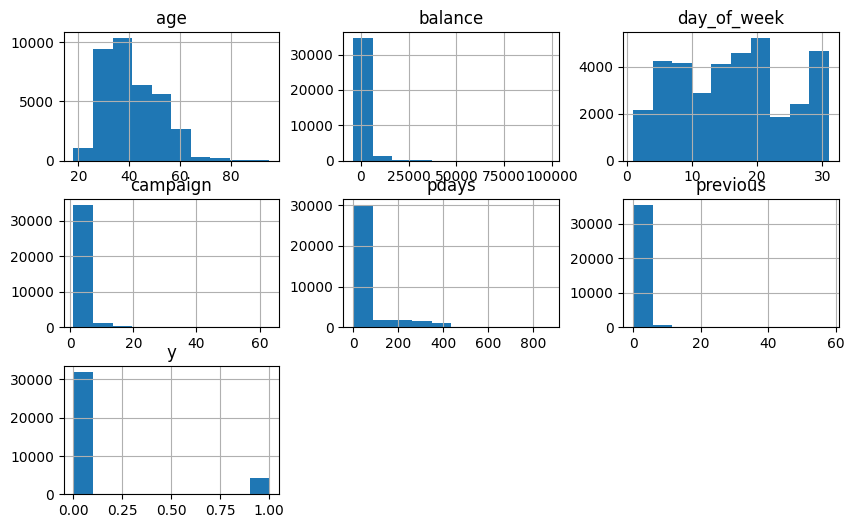

In [136]:
df_full[num].hist(figsize=(10,6))
# df_full[num].boxplot(figsize=(10,6))

#### analysis of target variable ...


In [130]:
df_full.y.value_counts(normalize=True)

y
0    0.881998
1    0.118002
Name: proportion, dtype: float64

#### feature importance analysis ...

In [131]:
df_full[cat].nunique()

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
dtype: int64

In [132]:
from IPython.display import display

In [135]:
global_y = df_full.y.mean()

for c in cat:
    print(c)
    df_group = df_full.groupby(c).y.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_y
    df_group['risk'] = df_group['mean'] / global_y
    display(df_group)
    print()
    print()

job


,mean,count,diff,risk
job,,,,
admin.,0.122035,4089,0.004033,1.034179
blue-collar,0.073152,7710,-0.044850,0.619922
entrepreneur,0.088797,1205,-0.029205,0.752504
housemaid,0.086614,1016,-0.031387,0.734008
management,0.138710,7613,0.020708,1.175493
retired,0.229053,1838,0.111052,1.941103
self-employed,0.118991,1269,0.000990,1.008387
services,0.088673,3293,-0.029329,0.751455
student,0.286290,744,0.168289,2.426156




marital


,mean,count,diff,risk
marital,,,,
divorced,0.123028,4121,0.005027,1.042599
married,0.101953,21814,-0.016049,0.863996
single,0.150186,10234,0.032184,1.272742




education


,mean,count,diff,risk
education,,,,
primary,0.085558,5470,-0.032444,0.725054
secondary,0.106519,18485,-0.011483,0.902689
tertiary,0.151512,10745,0.033511,1.283985
unknown,0.138189,1469,0.020188,1.171079




default


,mean,count,diff,risk
default,,,,
no,0.118878,35507,0.000876,1.007427
yes,0.070997,662,-0.047005,0.601661




housing


,mean,count,diff,risk
housing,,,,
no,0.168464,16134,0.050463,1.427643
yes,0.077365,20035,-0.040637,0.655623




loan


,mean,count,diff,risk
loan,,,,
no,0.127225,30387,0.009224,1.078167
yes,0.069526,5782,-0.048475,0.589196




contact


,mean,count,diff,risk
contact,,,,
cellular,0.149448,23453,0.031446,1.266490
telephone,0.138807,2363,0.020805,1.176311
unknown,0.042017,10353,-0.075985,0.356070




month


,mean,count,diff,risk
month,,,,
apr,0.206282,2356,0.088280,1.748127
aug,0.111735,4985,-0.006266,0.946896
dec,0.485380,171,0.367379,4.113335
feb,0.164396,2129,0.046395,1.393171
jan,0.097988,1143,-0.020014,0.830393
jul,0.093090,5543,-0.024911,0.788891
jun,0.102400,4209,-0.015602,0.867782
mar,0.514667,375,0.396665,4.361523
may,0.067863,11037,-0.050139,0.575099




poutcome


,mean,count,diff,risk
poutcome,,,,
failure,0.125095,3933,0.007094,1.060116
other,0.166106,1487,0.048105,1.407661
success,0.657477,1197,0.539475,5.571763
unknown,0.092786,29552,-0.025216,0.786308


In [ ]:
# create the correlation matrix for the numerical features
corr_matrix = df[df.columns[df.dtypes!='object'].tolist()].corr()
corr_matrix

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix)
plt.title('Numeric Columns Correlation Heatmap')
plt.show()

#### feature importance ...


### training

Train multiple models and tune their parameters

For neural networks: same as previous, but also with tuning: adjusting learning rate, dropout rate, size of the inner layer, etc.

#### one-hot encoding

In [15]:
# one-hot encode features
def one_hot_encode(train_df, test_df, features):
    train_dict=train_df[features].to_dict(orient='records')
    val_dict=test_df[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)
        
    return dv.transform(train_dict), dv.transform(val_dict)

In [22]:
X_train, X_val = one_hot_encode(df_train, df_val, cat+num)

#### logistic regression

In [25]:
# train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_proba_pred = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)

In [35]:
print(f"the model's auc score is: {roc_auc_score(y_val, y_pred):.3f}")

the model's auc score is: 0.579


#### random forest

#### xgboost

#### nueral network

### evaluation

#### evaluate accuracy at different thresholds

In [37]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

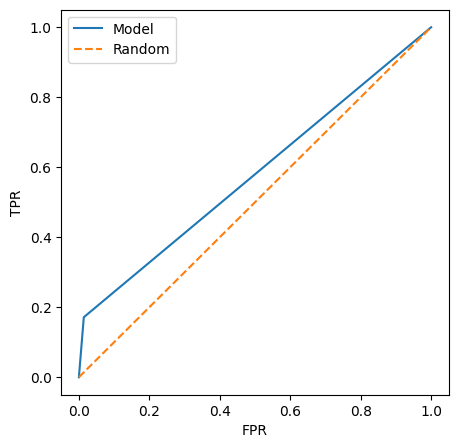

In [38]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()